1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to graphically display the regions.
* Use `scipy.optimize.minimize()`, trying its optional arguments.

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy import optimize
from scipy.optimize import differential_evolution
from scipy.optimize import basinhopping
from scipy.integrate import odeint
from numpy import sin, cos
from scipy import fftpack
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def f(x):
    return (4 - 2.1 * x[0]**2 + (x[0]**4)/3) * x[0]**2 + x[0]*x[1] + (4*x[1]**2 - 4) * x[1]**2

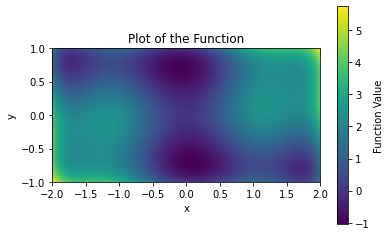

In [3]:
x = np.linspace(-2, 2, 400)
y = np.linspace(-1, 1, 200)
X, Y = np.meshgrid(x, y)

Z = f([X, Y])

plt.imshow(Z, extent=[-2, 2, -1, 1], origin='lower', cmap='viridis')
plt.colorbar(label='Function Value')
plt.title('Plot of the Function')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

From the plot, it looks like there might be two global minima. Bottom right corner and top left corner looks like local minimas. 

**Find global minimas:**

In [4]:
def find_global_minima(f, num_minima, bounds=(-10, 10)):
    minima = []
    for _ in range(num_minima):
        x0 = [np.random.uniform(bounds[0], bounds[1]) for _ in range(2)]
        solution = basinhopping(f, x0, stepsize=1, minimizer_kwargs={'method': 'L-BFGS-B'})
        minima.append(solution.x)
    return minima

#Assuming there are two global minima, as it looks like on the plot
num_minima = 2
global_minima = find_global_minima(f, num_minima)

for i, minima in enumerate(global_minima, 1):
    print(f"Global Minimum {i}: {minima}, Function Value: {f(minima)}")

Global Minimum 1: [-0.08984202  0.7126564 ], Function Value: -1.0316284534898772
Global Minimum 2: [ 0.08984201 -0.71265641], Function Value: -1.0316284534898772


**When the initial guess is [0,0]**

In [5]:
initial_guess = [0, 0]
bounds = [(-25, 25), (-25, 25)]
result = minimize(f, initial_guess, bounds=bounds, method='L-BFGS-B')

print("Global minimum found at:", result.x)
print("Minimum function value:", result.fun)
print('When the inital guess is (0,0), the result is that the global minimum is found there. This might be because it is a local minima.')

Global minimum found at: [0. 0.]
Minimum function value: 0.0
When the inital guess is (0,0), the result is that the global minimum is found there. This might be because it is a local minima.


**Plot with the global minimas**

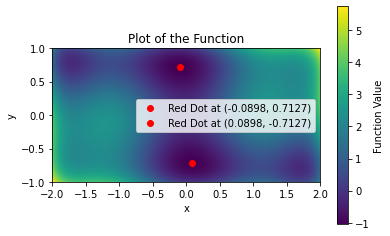

In [6]:
plt.imshow(Z, extent=[-2, 2, -1, 1], origin='lower', cmap='viridis')
plt.colorbar(label='Function Value')
plt.title('Plot of the Function')
plt.xlabel('x')
plt.ylabel('y')

points = [(-0.0898, 0.7127),(0.0898, -0.7127)]
for point in points:
    plt.scatter(*point, color='red', marker='o', label=f'Red Dot at {point}')

plt.legend()
plt.show()

2\. **Non-linear ODE: the damped pendulum**

The equation of the motion of a forced pendulum, as a function of the angle $\theta$ with the vertical, is given by:

$$\frac{d^2\theta}{dt^2} = -\frac{1}{Q} \frac{d\theta}{dt} + \frac{g}{l}\sin\theta + d \cos\Omega t$$

where $t$ is time, $Q$ is the damping factor, $d$ is the forcing amplitude, and $\Omega$ is the driving frequency of the forcing. 

This second order ODE needs to be written as two coupled first order ODEs by defining a new variable $\omega \equiv d\theta/dt$:

$$\frac{d\theta}{dt} = \omega$$
$$\frac{d\omega}{dt} = -\frac{1}{Q}\,\omega + \frac{g}{l}\sin\theta + d \cos\Omega t$$

Consider the initial conditions $\theta_0 = \omega_0 = 0$, and $l = 10$, $Q = 2.0$, $d = 1.5$, and $\omega = 0.65$.

 - Solve the ODE with `odeint` over a period of 200 time steps
 - Create two plots, one of $\theta$ as a function of the time, and $\omega$ as a function of the time
 - **Optional**: determine if there is a set of parameters for which the motion is chaotic.

In [7]:
def derivative_omega(state, t, Q, g, l, theta, b_omega, d):
    theta, omega = state
    dtheta_dt = omega
    domega_dt = -(1/Q)*omega + (g/l)*np.sin(theta) + d*np.cos(b_omega*t)
    return [dtheta_dt, domega_dt]

In [8]:
init_theta = 0
init_omega = 0
init_l = 10
init_Q = 2
init_d = 1.5
omega_val = 0.65
g = 9.8 # I assume g is 9.8 (gravity)
time = np.linspace(0, 200, 200)

y = odeint(derivative_omega, [init_theta, init_omega], time, args=(init_Q, g, init_l, init_theta, omega_val, init_d))

theta_solution, omega_solution = y.T

Plot of $\theta$ and $\omega$ over time 

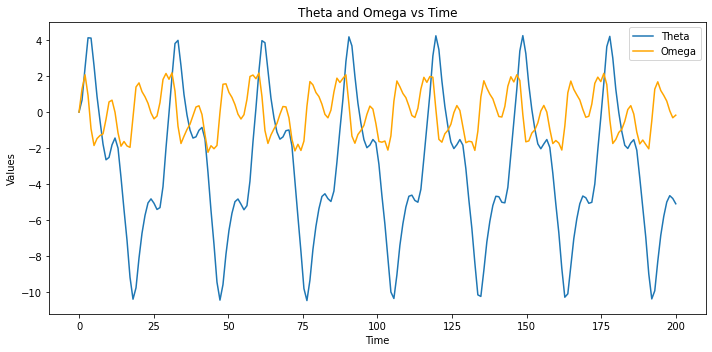

In [9]:
plt.figure(figsize=(10, 5))

plt.plot(time, theta_solution, label='Theta')
plt.plot(time, omega_solution, label='Omega', color='orange')

plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Theta and Omega vs Time')
plt.legend()

plt.tight_layout()
plt.show()

3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

The dataset is the one downloaded at the beginning of Lecture 06:

 - `!wget https://www.dropbox.com/s/ebe1cnyd2gm836a/populations.txt -P data/`

In [2]:
#!wget https://www.dropbox.com/s/ebe1cnyd2gm836a/populations.txt -P data/

Load and plot data

In [10]:
data = np.loadtxt('data/populations.txt')
year, hares, lynxes, carrots = data.T

# year	hare	lynx	carrot
1900	30e3	4e3	48300
1901	47.2e3	6.1e3	48200
1902	70.2e3	9.8e3	41500
1903	77.4e3	35.2e3	38200
1904	36.3e3	59.4e3	40600
1905	20.6e3	41.7e3	39800
1906	18.1e3	19e3	38600
1907	21.4e3	13e3	42300
1908	22e3	8.3e3	44500
1909	25.4e3	9.1e3	42100
1910	27.1e3	7.4e3	46000
1911	40.3e3	8e3	46800
1912	57e3	12.3e3	43800
1913	76.6e3	19.5e3	40900
1914	52.3e3	45.7e3	39400
1915	19.5e3	51.1e3	39000
1916	11.2e3	29.7e3	36700
1917	7.6e3	15.8e3	41800
1918	14.6e3	9.7e3	43300
1919	16.2e3	10.1e3	41300
1920	24.7e3	8.6e3	47300


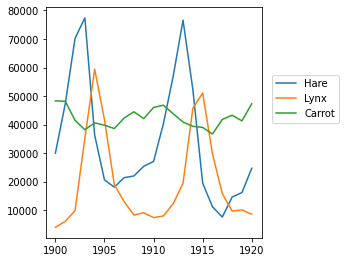

In [16]:
# E: exploring data
!cat data/populations.txt
%matplotlib inline

plt.axes([0.2, 0.1, 0.5, 0.8]) 
plt.plot(year, hares, year, lynxes, year, carrots) 
plt.legend(('Hare', 'Lynx', 'Carrot'), loc=(1.05, 0.5))

FFT of both lynxes and hares 

In [17]:
lynxes_fft = fftpack.fft(lynxes)
lynxes_psd = np.abs(lynxes_fft) ** 2
lynxes_fftfreq = fftpack.fftfreq(len(lynxes_psd), 1. / 20)

hares_fft = fftpack.fft(hares)
hares_psd = np.abs(hares_fft) ** 2
hares_fftfreq = fftpack.fftfreq(len(hares_psd), 1. / 20)

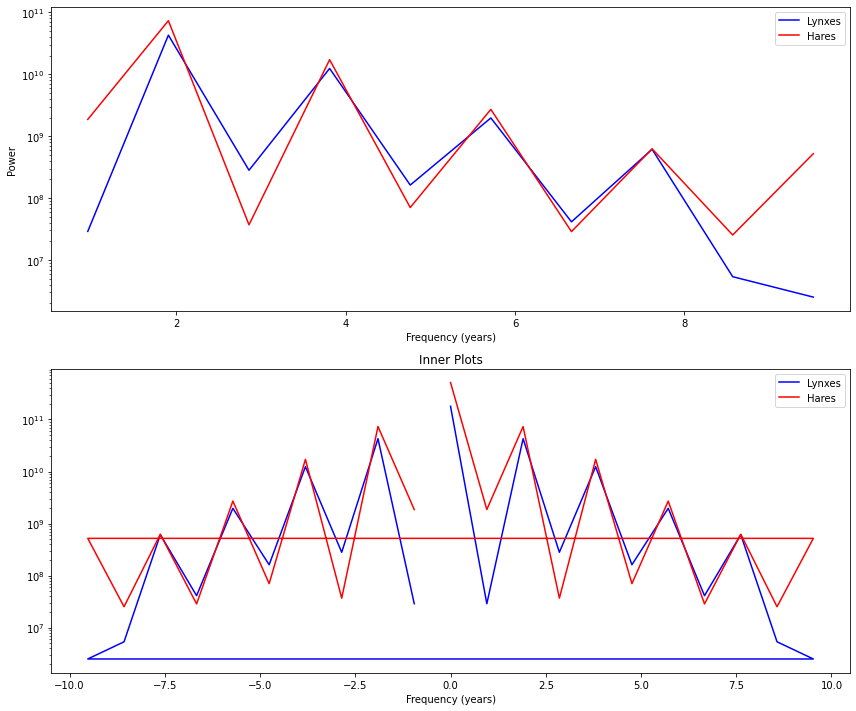

It seems the period of the population peaks are every two years


In [21]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Power spectra plot
axes[0].plot(lynxes_fftfreq[lynxes_fftfreq > 0], lynxes_psd[lynxes_fftfreq > 0], color='blue', label='Lynxes')
axes[0].plot(hares_fftfreq[hares_fftfreq > 0], hares_psd[hares_fftfreq > 0], color='red', label='Hares')
axes[0].set_xlabel('Frequency (years)')
axes[0].set_ylabel('Power')
axes[0].set_yscale('log')
axes[0].legend()

# Inner plots
axes[1].plot(lynxes_fftfreq[:40], lynxes_psd[:40], color='blue', label='Lynxes')
axes[1].plot(hares_fftfreq[:40], hares_psd[:40], color='red', label='Hares')
axes[1].set_yscale('log')
axes[1].set_xlabel('Frequency (years)')
axes[1].set_title('Inner Plots')
axes[1].legend()

plt.tight_layout()
plt.show()
print('It seems the period of the population peaks are every two years')

4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("images/moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the 2D regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

<function matplotlib.pyplot.show(close=None, block=None)>

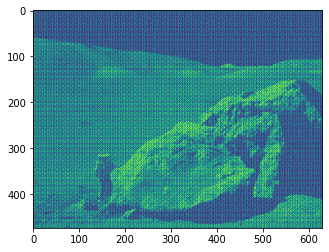

In [22]:
image = plt.imread("images/moonlanding.png")
plt.imshow(image)
plt.show

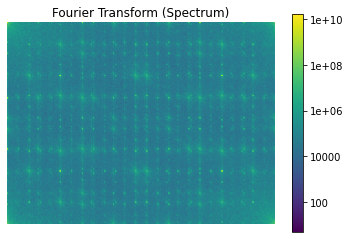

In [77]:
image_fft = fftpack.fft2(image)
image_psd = np.abs(image_fft) ** 2

plt.imshow(image_psd, cmap='viridis', norm=LogNorm(vmin=5))
plt.title('Fourier Transform (Spectrum)')
plt.colorbar(format='%g')
plt.axis('off')

plt.show()

In [78]:
noise_threshold_min = 1e+07 #values chosen based on above plot
noise_threshold_max = 1e+10
noise_mask = (image_psd >= noise_threshold_min) & (image_psd <= noise_threshold_max)

image_psd[noise_mask] = 0

# Remove the noise and inverse shift 
new_image_fft = image_fft * np.sqrt(image_psd) / np.abs(image_fft)
new_image = np.abs(fftpack.ifft2(new_image_fft))

Plot of the original image and the image with noise removed

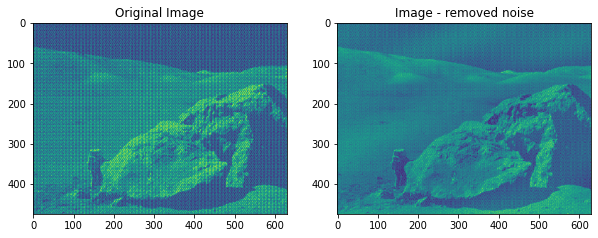

In [81]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image)
axs[0].set_title('Original Image')

axs[1].imshow(new_image)
axs[1].set_title('Image - removed noise')

plt.show()

It looks like there is still som noise present, but lowering the min-value for the noise seemed to remove some of the actual image as well. 